In [26]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer, cosine_distance
from sklearn import metrics
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [10]:
data = pd.read_excel("Design.xls").dropna()
data.describe()

,text,cate,label,state
count,7043,7043,7043,7043
unique,7043,1,7,4
top,Canvas Art Parties (Canceled) A community for ...,design,graphic design,1
freq,1,7043,2400,3823


In [11]:
train, test = train_test_split(data, test_size = 0.2, random_state=30)
print(data["text"][0])

The Tree House Project As an architectural, experimental investigation, the goal is to construct and build a tree house, by myself, up in a pine tree.


In [18]:
stop = list(stopwords.words('english')) + ['design']

In [19]:
tfidf_vect = TfidfVectorizer(stop_words=stop, min_df=2) 
dtm= tfidf_vect.fit_transform(train["text"].values.astype('U'))
print (dtm.shape)

(5634, 6762)


In [20]:
# set number of clusters
num_clusters=7

# initialize clustering model
# using cosine distance
# clustering will repeat 20 times
# each with different initial centroids
clusterer = KMeansClusterer(num_clusters, \
                            cosine_distance, \
                            repeats=20)

# samples are assigned to cluster labels 
# starting from 0
clusters = clusterer.cluster(dtm.toarray(), \
                             assign_clusters=True)

#print the cluster labels of the first 5 samples
print(clusters[0:5])

C:\Users\Tianhao Ruan\anaconda3\lib\site-packages\nltk\cluster\util.py:131: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


[2, 0, 0, 2, 6]


In [21]:
# clusterer.means() contains the centroids
# each row is a cluster, and 
# each column is a feature (word)
centroids=np.array(clusterer.means())

# argsort sort the matrix in ascending order 
# and return locations of features before sorting
# [:,::-1] reverse the order
sorted_centroids = centroids.argsort()[:, ::-1] 

# The mapping between feature (word)
# index and feature (word) can be obtained by
# the vectorizer's function get_feature_names()
voc_lookup= tfidf_vect.get_feature_names()

for i in range(num_clusters):
    
    # get words with top 20 tf-idf weight in the centroid
    top_words=[voc_lookup[word_index] \
               for word_index in sorted_centroids[i, :20]]
    print("Cluster %d:\n %s " % (i, "; ".join(top_words)))

Cluster 0:
 enamel; poster; cards; pins; pin; series; posters; prints; collection; de; art; printed; playing; inspired; edition; limited; map; calendar; 3d; deck 
Cluster 1:
 unique; font; hand; typeface; handmade; gift; family; fonts; style; paper; type; leather; art; wrap; typefaces; wrapping; designs; 100; make; designed 
Cluster 2:
 help; project; graphic; build; book; get; us; people; create; logo; business; canceled; want; make; shirt; show; need; stickers; park; community 
Cluster 3:
 house; made; home; space; tiny; knife; sustainable; eco; titanium; building; pen; community; friendly; living; plastic; recycled; designed; modern; build; green 
Cluster 4:
 one; tool; life; easy; way; coffee; use; make; light; world; better; toy; play; kids; fun; multi; water; planner; first; bottle 
Cluster 5:
 bag; wallet; mask; backpack; stand; travel; portable; phone; pillow; case; face; designed; camera; laptop; go; pack; leather; compact; carry; world 
Cluster 6:
 new; watch; watches; automa

In [22]:
test_dtm = tfidf_vect.transform(test["text"].values.astype('U'))

predicted = [clusterer.classify(v) for v in test_dtm.toarray()]

predicted[0:10]

[1, 3, 4, 0, 3, 0, 3, 4, 2, 3]

In [23]:
confusion_df = pd.DataFrame(list(zip(test["label"].values, predicted)), columns = ["label", "cluster"])
df1=pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)
df1

cluster_dict=dict(df1.idxmax(axis=1))
predicted_target=[cluster_dict[i] for i in predicted]
print(metrics.classification_report(test["label"], predicted_target))

label,architecture,civic design,graphic design,interactive design,product design,toys,typography
cluster,,,,,,,
0,11,3,202,6,49,13,7
1,5,1,30,8,15,0,14
2,81,42,159,29,10,5,6
3,69,13,19,16,88,5,0
4,20,12,57,31,114,8,3
5,5,1,5,4,138,1,0
6,10,10,17,12,53,2,0


                    precision    recall  f1-score   support

      architecture       0.00      0.00      0.00       201
      civic design       0.00      0.00      0.00        82
    graphic design       0.56      0.80      0.66       489
interactive design       0.00      0.00      0.00       106
    product design       0.55      0.84      0.67       467
              toys       0.00      0.00      0.00        34
        typography       0.00      0.00      0.00        30

          accuracy                           0.56      1409
         macro avg       0.16      0.23      0.19      1409
      weighted avg       0.38      0.56      0.45      1409



C:\Users\Tianhao Ruan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
data.label = data.label.replace('toys','product design')
data.label = data.label.replace('typography','graphic design')
data.label = data.label.replace('civic design','environment design')
data.label = data.label.replace('architecture','environment design')
data.label = data.label.replace('interactive design','graphic design')
data.groupby('label').count()

,text,cate,state
label,,,
environment design,1312,1312,1312
graphic design,3114,3114,3114
product design,2617,2617,2617


In [28]:
train, test = train_test_split(data, test_size = 0.2, random_state=30)

tfidf_vect = TfidfVectorizer(stop_words=stop, min_df=2) 
dtm= tfidf_vect.fit_transform(train["text"].values.astype('U'))

clusterer = KMeansClusterer(3, \
                            cosine_distance, \
                            repeats=20)

clusters = clusterer.cluster(dtm.toarray(), \
                             assign_clusters=True)

centroids=np.array(clusterer.means())

centroids=np.array(clusterer.means())

voc_lookup= tfidf_vect.get_feature_names()

for i in range(3):
    
    # get words with top 20 tf-idf weight in the centroid
    top_words=[voc_lookup[word_index] \
               for word_index in sorted_centroids[i, :20]]
    print("Cluster %d:\n %s " % (i, "; ".join(top_words)))

C:\Users\Tianhao Ruan\anaconda3\lib\site-packages\nltk\cluster\util.py:131: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


Cluster 0:
 enamel; poster; cards; pins; pin; series; posters; prints; collection; de; art; printed; playing; inspired; edition; limited; map; calendar; 3d; deck 
Cluster 1:
 unique; font; hand; typeface; handmade; gift; family; fonts; style; paper; type; leather; art; wrap; typefaces; wrapping; designs; 100; make; designed 
Cluster 2:
 help; project; graphic; build; book; get; us; people; create; logo; business; canceled; want; make; shirt; show; need; stickers; park; community 


In [29]:
test_dtm = tfidf_vect.transform(test["text"].values.astype('U'))

predicted = [clusterer.classify(v) for v in test_dtm.toarray()]

confusion_df = pd.DataFrame(list(zip(test["label"].values, predicted)), columns = ["label", "cluster"])

df1=pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)

df1

cluster_dict=dict(df1.idxmax(axis=1))
predicted_target=[cluster_dict[i] for i in predicted]
print(metrics.classification_report(test["label"], predicted_target))

label,environment design,graphic design,product design
cluster,,,
0,17,291,80
1,242,268,47
2,24,66,374


                    precision    recall  f1-score   support

environment design       0.00      0.00      0.00       283
    graphic design       0.59      0.89      0.71       625
    product design       0.81      0.75      0.78       501

          accuracy                           0.66      1409
         macro avg       0.47      0.55      0.50      1409
      weighted avg       0.55      0.66      0.59      1409



C:\Users\Tianhao Ruan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1152x288 with 0 Axes>

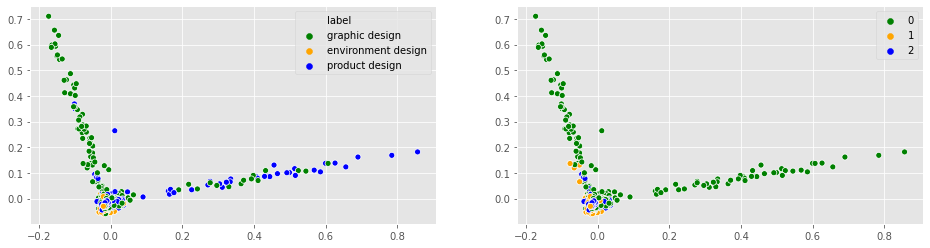

In [30]:
plt.style.use('ggplot')
pca = PCA(n_components=2)
X = pca.fit_transform(test_dtm.toarray())

plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue = test["label"], palette=['green','orange','blue'] )

plt.subplot(1,2,2)
sns.scatterplot(x=X[:,0], y=X[:,1], hue = predicted, palette=['green','orange','blue'] )
plt.show()

In [31]:
train, test = train_test_split(data, test_size = 0.2, random_state=30)

tfidf_vect = TfidfVectorizer(stop_words=stop, min_df=2) 
dtm= tfidf_vect.fit_transform(train["text"].values.astype('U'))

clusterer = KMeansClusterer(4, \
                            cosine_distance, \
                            repeats=20)

clusters = clusterer.cluster(dtm.toarray(), \
                             assign_clusters=True)

centroids=np.array(clusterer.means())

centroids=np.array(clusterer.means())

voc_lookup= tfidf_vect.get_feature_names()

for i in range(4):
    
    # get words with top 20 tf-idf weight in the centroid
    top_words=[voc_lookup[word_index] \
               for word_index in sorted_centroids[i, :20]]
    print("Cluster %d:\n %s " % (i, "; ".join(top_words)))

C:\Users\Tianhao Ruan\anaconda3\lib\site-packages\nltk\cluster\util.py:131: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


Cluster 0:
 enamel; poster; cards; pins; pin; series; posters; prints; collection; de; art; printed; playing; inspired; edition; limited; map; calendar; 3d; deck 
Cluster 1:
 unique; font; hand; typeface; handmade; gift; family; fonts; style; paper; type; leather; art; wrap; typefaces; wrapping; designs; 100; make; designed 
Cluster 2:
 help; project; graphic; build; book; get; us; people; create; logo; business; canceled; want; make; shirt; show; need; stickers; park; community 
Cluster 3:
 house; made; home; space; tiny; knife; sustainable; eco; titanium; building; pen; community; friendly; living; plastic; recycled; designed; modern; build; green 


In [32]:
test_dtm = tfidf_vect.transform(test["text"].values.astype('U'))

predicted = [clusterer.classify(v) for v in test_dtm.toarray()]

confusion_df = pd.DataFrame(list(zip(test["label"].values, predicted)), columns = ["label", "cluster"])

df1=pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)

df1

cluster_dict=dict(df1.idxmax(axis=1))
predicted_target=[cluster_dict[i] for i in predicted]
print(metrics.classification_report(test["label"], predicted_target))

label,environment design,graphic design,product design
cluster,,,
0,0,26,46
1,38,381,48
2,226,173,46
3,19,45,361


                    precision    recall  f1-score   support

environment design       0.51      0.80      0.62       283
    graphic design       0.82      0.61      0.70       625
    product design       0.82      0.81      0.82       501

          accuracy                           0.72      1409
         macro avg       0.71      0.74      0.71      1409
      weighted avg       0.76      0.72      0.72      1409



<Figure size 1152x288 with 0 Axes>

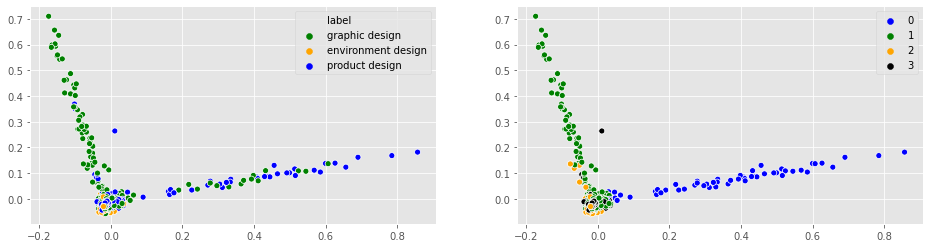

In [34]:
plt.style.use('ggplot')
pca = PCA(n_components=2)
X = pca.fit_transform(test_dtm.toarray())

plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue = test["label"], palette=['green','orange','blue'] )

plt.subplot(1,2,2)
sns.scatterplot(x=X[:,0], y=X[:,1], hue = predicted, palette=['blue','green','orange','black'] )
plt.show()